# Inbalanced Classes
## In this lab, we are going to explore a case of imbalanced classes. 


Like we discussed in class, when we have noisy data, if we are not careful, we can end up fitting our model to the noise in the data and not the 'signal' - the factors that actually determine the outcome. This is called overfitting, and results in good results in training, and in bad results when the model is applied to real data. Similarly, we could have a model that is too simplistic to accurately model the signal. This produces a model that doesnt work well (ever). 


### Note: before doing the first commit, make sure you don't include the large csv file, either by adding it to .gitignore, or by deleting it.

### First, download the data from: https://www.kaggle.com/ntnu-testimon/paysim1. Import the dataset and provide some discriptive statistics and plots. What do you think will be the important features in determining the outcome?
### Note: don't use the entire dataset, use a sample instead, with n=100000 elements, so your computer doesn't freeze.

In [40]:
# Your code here
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix

In [2]:
fraud = pd.read_csv('PS_20174392719_1491204439457_log.csv')

In [3]:
fraud.shape

(6362620, 11)

In [4]:
fraud = fraud.sample(n=100000)

In [5]:
fraud.shape

(100000, 11)

In [6]:
fraud.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
4542630,326,PAYMENT,7461.91,C23861281,0.00,0.00,M652092904,0.00,0.00,0,0
1560503,155,CASH_OUT,275417.35,C499443471,20760.00,0.00,C254607175,0.00,275417.35,0,0
4236849,306,CASH_IN,61477.79,C1751998103,11713.00,73190.79,C668744126,429517.77,368039.98,0,0
4145084,303,CASH_OUT,145097.63,C648593091,0.00,0.00,C1549186254,1262963.72,1408061.35,0,0
4239605,306,CASH_OUT,258241.54,C1634084299,14222.42,0.00,C1509931079,466870.10,725111.64,0,0


In [7]:
fraud.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,100000.000000,1.000000e+05,1.000000e+05,1.000000e+05,1.000000e+05,1.000000e+05,100000.000000,100000.0
mean,243.155590,1.825052e+05,8.407251e+05,8.616511e+05,1.096690e+06,1.222713e+06,0.001260,0.0
std,141.836024,6.303363e+05,2.891316e+06,2.927646e+06,3.453977e+06,3.734556e+06,0.035474,0.0
min,1.000000,5.800000e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.0
25%,156.000000,1.329344e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.0
50%,239.000000,7.402464e+04,1.418800e+04,0.000000e+00,1.277332e+05,2.156918e+05,0.000000,0.0
75%,334.000000,2.087491e+05,1.073868e+05,1.444660e+05,9.412616e+05,1.106502e+06,0.000000,0.0
max,743.000000,5.957950e+07,3.372506e+07,3.400376e+07,3.215898e+08,3.555534e+08,1.000000,0.0


In [8]:
fraud.columns

Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud'],
      dtype='object')

In [9]:
#sns.pairplot(fraud[['type','amount','oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest','isFraud','isFlaggedFraud']])

In [10]:
"""
I think the most important features in determining the outcome ('isFraud') are the 'amount' and the 'oldbalanceOrg'.
"""

"\nI think the most important features in determining the outcome ('isFraud') are the 'amount' and the 'oldbalanceOrg'.\n"

### What is the distribution of the outcome? 

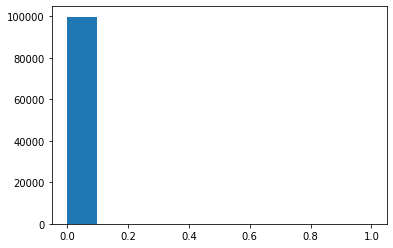

In [11]:
# Your response here
plt.hist(fraud['isFraud'])
plt.show()

In [12]:
fraud['isFraud'].value_counts(normalize=True)

0    0.99874
1    0.00126
Name: isFraud, dtype: float64

In [13]:
"""
There are moslty 0's, the 1's are not even visible in the histogram.
"""

"\nThere are moslty 0's, the 1's are not even visible in the histogram.\n"

### Clean the dataset. How are you going to integrate the time variable? Do you think the step (integer) coding in which it is given is appropriate?

In [14]:
# Your code here
fraud.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 4542630 to 3665634
Data columns (total 11 columns):
step              100000 non-null int64
type              100000 non-null object
amount            100000 non-null float64
nameOrig          100000 non-null object
oldbalanceOrg     100000 non-null float64
newbalanceOrig    100000 non-null float64
nameDest          100000 non-null object
oldbalanceDest    100000 non-null float64
newbalanceDest    100000 non-null float64
isFraud           100000 non-null int64
isFlaggedFraud    100000 non-null int64
dtypes: float64(5), int64(3), object(3)
memory usage: 9.2+ MB


In [15]:
fraud['isFlaggedFraud'].value_counts()

0    100000
Name: isFlaggedFraud, dtype: int64

In [16]:
# I'll drop this columns as there are only zeros
fraud.drop(columns=['isFlaggedFraud'], inplace=True)

In [17]:
fraud.shape

(100000, 10)

In [18]:
fraud['nameOrig'].nunique()

99997

In [19]:
# I'll drop this column as all entries are unique and also categorical type thus useless to predict the outcome
fraud.drop(columns=['nameOrig'], inplace=True)

In [20]:
fraud.shape

(100000, 9)

In [21]:
fraud['nameDest'].nunique()

92915

In [22]:
# I'll drop this column as most entries are unique and also categorical type thus useless to predict the outcome
fraud.drop(columns=['nameDest'], inplace=True)

In [23]:
fraud.shape

(100000, 8)

In [24]:
fraud.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
4542630,326,PAYMENT,7461.91,0.00,0.00,0.00,0.00,0
1560503,155,CASH_OUT,275417.35,20760.00,0.00,0.00,275417.35,0
4236849,306,CASH_IN,61477.79,11713.00,73190.79,429517.77,368039.98,0
4145084,303,CASH_OUT,145097.63,0.00,0.00,1262963.72,1408061.35,0
4239605,306,CASH_OUT,258241.54,14222.42,0.00,466870.10,725111.64,0


In [25]:
fraud['type'].value_counts()

CASH_OUT    34896
PAYMENT     33944
CASH_IN     22100
TRANSFER     8376
DEBIT         684
Name: type, dtype: int64

In [26]:
# I'll convert the 'type' from categorical to numeric
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
fraud['type'] = le.fit_transform(fraud['type'])

In [27]:
fraud.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
4542630,326,3,7461.91,0.00,0.00,0.00,0.00,0
1560503,155,1,275417.35,20760.00,0.00,0.00,275417.35,0
4236849,306,0,61477.79,11713.00,73190.79,429517.77,368039.98,0
4145084,303,1,145097.63,0.00,0.00,1262963.72,1408061.35,0
4239605,306,1,258241.54,14222.42,0.00,466870.10,725111.64,0


In [28]:
fraud['type'].value_counts()

1    34896
3    33944
0    22100
4     8376
2      684
Name: type, dtype: int64

In [29]:
"""
0 CASH_IN
1 CASH_OUT
2 DEBIT
3 PAYMENT
4 TRANSFER
"""

'\n0 CASH_IN\n1 CASH_OUT\n2 DEBIT\n3 PAYMENT\n4 TRANSFER\n'

In [30]:
"""
Regarding the 'step' I think it might be more appropriate to have it in a date-time format because there might be an hour or day
pattern for fraud likelihood.
I've done this but then I cannot run the models with a date-time type so I'll keep it as integer.

fraud['step'] = pd.to_datetime(fraud['step'], unit='h')
"""

"\nRegarding the 'step' I think it might be more appropriate to have it in a date-time format because there might be an hour or day\npattern for fraud likelihood.\nI've done this but then I cannot run the models with a date-time type so I'll keep it as integer.\n\nfraud['step'] = pd.to_datetime(fraud['step'], unit='h')\n"

### Run a logisitc regression classifier and evaluate its accuracy.

In [35]:
# Your code here
X = fraud.drop(columns=['isFraud'])
y = fraud['isFraud']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=29)

In [37]:
lr = LogisticRegression(solver='lbfgs')
lr.fit(X_train, y_train)
acc = lr.score(X_test, y_test) * 100
acc

99.995

In [42]:
y_pred = lr.predict(X_test)
confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
precision = tp/(tp+fp)*100
recall = tp/(tp+fn)*100
precision, recall

(96.29629629629629, 100.0)

### Now pick a model of your choice and evaluate its accuracy.

In [39]:
# Your code here
dtc = DecisionTreeClassifier()
dtc.fit(X_train, y_train)
acc = dtc.score(X_test, y_test)*100
acc

99.97500000000001

In [43]:
y_pred = dtc.predict(X_test)
confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
precision = tp/(tp+fp)*100
recall = tp/(tp+fn)*100
precision, recall

(88.88888888888889, 92.3076923076923)

### Which model worked better and how do you know?

In [34]:
# Your response here
"""
The logistic regression model performs better than the decision tree because it has higher accuracy, precision and recall.
"""

### Note: before doing the first commit, make sure you don't include the large csv file, either by adding it to .gitignore, or by deleting it.